In [47]:
# Importing packages

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
notebook_dir = os.getcwd()
python_dir = os.path.dirname(notebook_dir)

sys.path.append(python_dir)

from validation import walk_forward_validation, plot_walk_forward_results

c:\Users\Christine\Documents\Python\Speciale_Kode


ImportError: cannot import name 'plot_walk_forward_results' from 'validation' (c:\Users\Christine\Documents\Python\Speciale_Kode\Shallow learners\..\validation.py)

In [37]:
# Loading and processing the data

# Determining the path to the data
file_dir = os.path.dirname(os.path.realpath('SVM_test.ipynb'))
python_dir = os.path.dirname(file_dir)
data_folder = os.path.join(python_dir, 'Data')
data_file = os.path.join(data_folder, 'combined_data_cleaned_v2.csv')

# Loading the data
df = pd.read_csv(data_file, decimal = ',')

# Changing the datatype
cols = ['OffshoreWindPower',
        'OnshoreWindPower',
        'HydroPower',
        'SolarPower',
        'Biomass',
        'Biogas',
        'Waste',
        'FossilGas',
        'FossilOil',
        'FossilHardCoal',
        'ExchangeGreatBelt',
        'ExchangeGermany',
        'ExchangeSweden',
        'ExchangeNorway',
        'ExchangeNetherlands',
        'WindSpeed',
        'Radiation',
        'DKPrice',
        'DEPrice',
        'NO2Price',
        'SE3Price',
        'SE4Price',
        'OffshoreWindCapacity',
        'OnshoreWindCapacity',
        'SolarPowerCapacity',
        'GrossCon']

power_cols = ['OffshoreWindPower',
        'OnshoreWindPower',
        'HydroPower',
        'SolarPower',
        'Biomass',
        'Biogas',
        'Waste',
        'FossilGas',
        'FossilOil',
        'FossilHardCoal']

df[cols] = df[cols].astype(float)

df['TotalPower'] = df[power_cols].sum(axis=1)

date_format = '%Y-%m-%d %H:%M:%S'

# Saving datetime format
temp_list = []
for i in list(df["TimeUTC"]):
    n = 19
    j = i[:n]
    k = datetime.strptime(j, date_format)
    temp_list.append(k)
df.insert(0, "Time", temp_list, True)
df = df.drop("TimeUTC", axis = 1)

df['TotalPower_lag1'] = df['TotalPower'].shift(1)  # value from 1 hour ago
df['TotalPower_lag24'] = df['TotalPower'].shift(24)  # value from 24 hours ago
df['Price_lag1'] = df['DKPrice'].shift(1)
df['Price_lag24'] = df['DKPrice'].shift(24)

df = df.dropna()

col = df.pop('DKPrice')
df.insert(0, 'DKPrice', col)

# Filtering for price zone
df_DK1 = df[df['DKZone'] == 'DK1']
df_DK1 = df_DK1.drop('DKZone', axis = 1)
df_DK1.reset_index(drop=True, inplace=True)
df_DK2 = df[df['DKZone'] == 'DK2']
df_DK2 = df_DK2.drop('DKZone', axis = 1)
df_DK2.reset_index(drop=True, inplace=True)

# Splitting between initial train and test set for DK1
DK1_train_set = df_DK1.loc[df_DK1['Time'] < pd.Timestamp('2025-01-01')]
DK1_train_set.set_index('Time', inplace=True)
DK1_train_set = DK1_train_set.asfreq('h')
DK1_train_set.index = DK1_train_set.index.tz_localize(None)
DK1_test_set = df_DK1.loc[df_DK1['Time'] >= pd.Timestamp('2025-01-01')]
DK1_test_set.set_index('Time', inplace=True)
DK1_test_set = DK1_test_set.asfreq('h')
DK1_test_set.index = DK1_test_set.index.tz_localize(None)

# Printing the shape for training and test date for DK1
print(f"Training data shape (DK1): {DK1_train_set.shape}")
print(f"Test data shape (DK1): {DK1_test_set.shape}")
print(f"Test set fraction (DK1): {len(DK1_test_set)/len(DK1_train_set):.2%}")

# Splitting between initial train and test set for DK2
DK2_train_set = df_DK2.loc[df_DK1['Time'] < pd.Timestamp('2025-01-01')]
DK2_train_set.set_index('Time', inplace=True)
DK2_train_set = DK2_train_set.asfreq('h')
DK2_train_set.index = DK2_train_set.index.tz_localize(None)
DK2_test_set = df_DK2.loc[df_DK1['Time'] >= pd.Timestamp('2025-01-01')]
DK2_test_set.set_index('Time', inplace=True)
DK2_test_set = DK2_test_set.asfreq('h')
DK2_test_set.index = DK2_test_set.index.tz_localize(None)

# Printing the shape for training and test date for DK2
print(f"Training data shape (DK2): {DK2_train_set.shape}")
print(f"Test data shape (DK2): {DK2_test_set.shape}")
print(f"Test set fraction (DK2): {len(DK2_test_set)/len(DK2_train_set):.2%}")

Training data shape (DK1): (78900, 31)
Test data shape (DK1): (8760, 31)
Test set fraction (DK1): 11.10%
Training data shape (DK2): (78900, 31)
Test data shape (DK2): (8760, 31)
Test set fraction (DK2): 11.10%


In [41]:
def make_svm_predict_fn(forecast_horizon):
    def predict_fn(train_data):

        X_train = train_data.iloc[:, 1:]  # all columns except target
        y_train = train_data.iloc[:, 0]   # target column

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        model = SVR(kernel='rbf')
        model.fit(X_train_scaled, y_train)

        # Predict autoregressively with frozen exogenous features
        last_row = X_train.iloc[-1:].copy()
        predictions = []

        for _ in range(forecast_horizon):
            X_scaled = scaler.transform(last_row)
            next_val = model.predict(X_scaled)[0]
            predictions.append(next_val)
            
            # Update lagged price columns with predicted value
            if 'Price_lag1' in last_row.columns:
                last_row['Price_lag1'] = next_val
            if 'Price_lag24' in last_row.columns:
                last_row['Price_lag24'] = next_val  # simplification
            # All other features (wind, solar, capacity) stay frozen

        return np.array(predictions)
    return predict_fn

In [42]:
svm_predict = make_svm_predict_fn(forecast_horizon = 168)

results_svm_DK1 = walk_forward_validation(
    data_series = DK1_train_set,
    predict_fn = svm_predict,
    training_window = 8760,
    forecast_horizon = 168,
    expanding = False
)

predictions_DK1, actuals_DK1, fold_rmse_DK1, fold_mae_DK1 = results_svm_DK1

Total folds: 416
Training window: 8760 hours
Forecast horizon: 168 hours
Mode: Sliding window

Fold 1/416
  Fold RMSE: 80.64, MAE: 53.76

Fold 2/416
  Fold RMSE: 49.40, MAE: 21.91

Fold 3/416
  Fold RMSE: 88.05, MAE: 34.47

Fold 4/416
  Fold RMSE: 30.22, MAE: 14.21

Fold 5/416
  Fold RMSE: 34.01, MAE: 22.12

Fold 6/416
  Fold RMSE: 50.67, MAE: 20.56

Fold 7/416
  Fold RMSE: 52.50, MAE: 28.75

Fold 8/416
  Fold RMSE: 102.09, MAE: 58.62

Fold 9/416
  Fold RMSE: 57.82, MAE: 38.60

Fold 10/416
  Fold RMSE: 67.54, MAE: 43.08

Fold 11/416
  Fold RMSE: 58.95, MAE: 32.66

Fold 12/416
  Fold RMSE: 58.07, MAE: 44.09

Fold 13/416
  Fold RMSE: 47.06, MAE: 35.23

Fold 14/416
  Fold RMSE: 76.63, MAE: 43.39

Fold 15/416
  Fold RMSE: 41.12, MAE: 19.80

Fold 16/416
  Fold RMSE: 70.98, MAE: 54.36

Fold 17/416
  Fold RMSE: 102.05, MAE: 89.84

Fold 18/416
  Fold RMSE: 82.85, MAE: 45.95

Fold 19/416
  Fold RMSE: 48.26, MAE: 34.01

Fold 20/416
  Fold RMSE: 37.59, MAE: 28.24

Fold 21/416
  Fold RMSE: 60.00, 

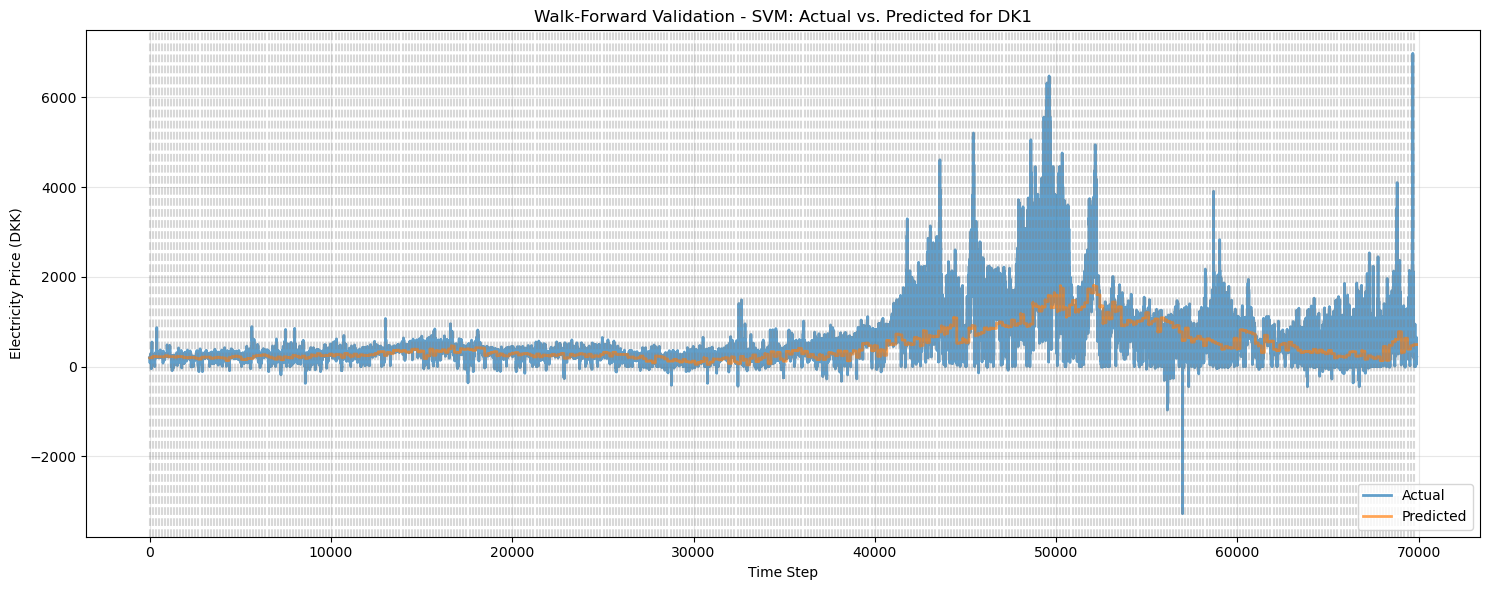

In [53]:
title_DK1 = 'Walk-Forward Validation - SVM: Actual vs. Predicted for DK1'

plot_walk_forward_results(
        predictions_DK1, 
        actuals_DK1, 
        title_DK1)